In [116]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from broyden import *
import time

Pi = sym.symbols('pi')
n0 = 0.153
hc = 197.326980 # MeV fm

In [117]:
class eos:
    def __init__(self, g_sigma, g_omega, g_rho = 0.0, b = 0.0, c = 0.0):
        
        self.g_sigma = g_sigma
        self.g_omega = g_omega
        self.g_rho = g_rho
        self.b = b
        self.c = c

class baryon:
    def __init__(self, mass, spin, isospin, charge, kind, var_type, mass_eff = 0.0, num_density = 0.0,\
                 frac = 0.0, kf = 0.0, ef = 0.0, chem_pot = 0.0):
    
        # variables to be established at baryon declaration
        self.mass = mass
        self.spin = spin 
        self.isospin = isospin
        self.charge = charge
        self.kind = kind
        self.var_type = var_type
    
        # variables to be stored later
        self.mass_eff = mass_eff
        self.num_density = num_density
        self.frac = frac
        self.kf = kf
        self.ef = ef
        self.chem_pot = chem_pot
        
        # other things
        self.g_sigma = 0.0
        self.g_omega = 0.0 
        self.g_rho = 0.0 
        self.g_phi = 0.0 

class lepton:
    def __init__(self, mass, charge, num_density = 0.0, frac = 0.0, var_type = 0.0, kf = 0.0, chem_pot = 0.0):
        self.mass = mass
        self.charge = charge
        self.num_density = num_density
        self.frac = frac
        self.var_type = var_type
        self.kf = kf
        self.chem_pot = chem_pot

class meson:
    def __init__(self, mass, field = 0.0):
        self.mass = mass # in MeV
        self.field = field
        
class independent_var:
    def __init__(self, var, func, tilde_chem_pot = 0.0, tilde_chem_pot_val = 0.0, num_val = 0.0, total_deriv = 0.0):
        self.var = var # var is the symbol for the variable
        self.func = func 
        
        self.tilde_chem_pot = tilde_chem_pot
        self.tilde_chem_pot_val = tilde_chem_pot_val
        
        self.num_val = num_val
        
        # total derivative of fraction wrt to nB
        self.total_deriv = total_deriv

In [118]:
# glen denning constants
rmf = eos(g_sigma = 8.79509376389, g_omega = 9.1815177, g_rho = 9.7793745, b = 0.00414, c = 0.00716)

g_sigma, g_omega, g_rho, b, c = sym.symbols('g_sigma, g_omega, g_rho, b, c')

# initializing symbolic eos object
rmf_sym = eos(g_sigma, g_omega, g_rho, b, c)

In [119]:
# electron
electron_sym = lepton(sym.symbols('m_e'), -1, sym.symbols('n_e'), sym.symbols('x_e'), 'Independent',\
                      sym.symbols('k_F_e'), sym.symbols('\mu_e'))
electron_num = lepton(0.510, -1)

# proton 
proton_sym = baryon(sym.symbols('m'), 1/2, 1/2, 1, 'Nucleon', 'Dependent', sym.symbols('m_p^*'),\
                    sym.symbols('n_p'), sym.symbols('x_p'), sym.symbols('k_F_p'),\
                    sym.symbols('E^*_F_p'), sym.symbols('mu_p'))
proton_num = baryon(939.0, 1/2, 1/2, 1, 'Nucleon', 'Dependent')

# neutron 
neutron_sym = baryon(sym.symbols('m'), 1/2, -1/2, 0, 'Nucleon', 'Dependent', sym.symbols('m_n^*'),\
                    sym.symbols('n_n'), sym.symbols('x_n'), sym.symbols('k_F_n'),\
                    sym.symbols('E^*_F_n'), sym.symbols('mu_n'))
neutron_num = baryon(939.0, 1/2, -1/2, 0, 'Nucleon', 'Dependent')

In [120]:
proton_sym.g_sigma = rmf_sym.g_sigma
proton_num.g_sigma = rmf.g_sigma

proton_sym.g_omega = rmf_sym.g_omega
proton_num.g_omega = rmf.g_omega

neutron_sym.g_sigma = rmf_sym.g_sigma
neutron_num.g_sigma = rmf.g_sigma

neutron_sym.g_omega = rmf_sym.g_omega
neutron_num.g_omega = rmf.g_omega

In [121]:
# declaring the symbolic meson objects
sigma_sym = meson(sym.symbols('m_sigma'), sym.symbols('sigma'))
omega_sym = meson(sym.symbols('m_omega'), sym.symbols('omega'))

# declaring the numeric meson objects
sigma_num = meson(550.0)
omega_num = meson(783.0)

In [122]:
# initializing independent variables
nb = independent_var(sym.symbols('n_B'), sym.Function('n_B'))
xe = independent_var(sym.symbols('x_e'), sym.Function('x_e'), sym.symbols('mu tilde_x_e'))

Practice with solving $\sigma-\omega$ Model
$$
    m_\sigma^2 \sigma + m_N b g_\sigma^3 \sigma^2 + c g_\sigma^4 \sigma^3 = g_\sigma n^s \qquad n^s = \frac{m^*}{\pi^2}\left[k_F E_F - {m^*}^2\ln\frac{k_F + E_F}{m^*}\right]\\
    m_\omega^2 \omega = g_\omega n_B
$$
with constraints
$$
    n_n + n_p = n_B\\
    n_p = n_e
$$

In [123]:
eqn1 = sigma_sym.mass**2*sigma_sym.field + neutron_sym.mass*rmf_sym.b*rmf_sym.g_sigma**3*sigma_sym.field**2 + rmf_sym.c*rmf_sym.g_sigma**4*sigma_sym.field**3 - rmf_sym.g_sigma*(sym.symbols('n_n^s') + sym.symbols('n_p^s'))
eqn1

b*g_sigma**3*m*sigma**2 + c*g_sigma**4*sigma**3 - g_sigma*(n_n^s + n_p^s) + m_sigma**2*sigma

In [124]:
ns_n = neutron_sym.mass_eff/Pi**2*(neutron_sym.kf*neutron_sym.ef - neutron_sym.mass_eff**2*sym.log((neutron_sym.kf + neutron_sym.ef)/neutron_sym.mass_eff))
ns_p = proton_sym.mass_eff/Pi**2*(proton_sym.kf*proton_sym.ef - proton_sym.mass_eff**2*sym.log((proton_sym.kf + proton_sym.ef)/proton_sym.mass_eff))

In [125]:
eqn1 = eqn1.subs([(sym.symbols('n_p^s'), ns_p), (sym.symbols('n_n^s'), ns_n)])
eqn1

b*g_sigma**3*m*sigma**2 + c*g_sigma**4*sigma**3 - g_sigma*(m_n^**(E^*_F_n*k_F_n - m_n^***2*log((E^*_F_n + k_F_n)/m_n^*))/pi**2 + m_p^**(E^*_F_p*k_F_p - m_p^***2*log((E^*_F_p + k_F_p)/m_p^*))/pi**2) + m_sigma**2*sigma

In [126]:
kf_n = (3*Pi**2*sym.symbols('n_n'))**(1/3)
kf_p = (3*Pi**2*sym.symbols('n_p'))**(1/3)
ef_n = sym.sqrt(kf_n**2 + (neutron_sym.mass - rmf_sym.g_sigma*sigma_sym.field)**2)
ef_p = sym.sqrt(kf_p**2 + (proton_sym.mass - rmf_sym.g_sigma*sigma_sym.field)**2)

In [127]:
eqn1 = eqn1.subs([(neutron_sym.kf, kf_n), (neutron_sym.ef, ef_n), (proton_sym.kf, kf_p), (proton_sym.ef, ef_p)])
eqn1 = eqn1.subs(neutron_sym.mass_eff, neutron_sym.mass - rmf_sym.g_sigma*sigma_sym.field)
eqn1 = eqn1.subs(proton_sym.mass_eff, proton_sym.mass - rmf_sym.g_sigma*sigma_sym.field)
eqn1

b*g_sigma**3*m*sigma**2 + c*g_sigma**4*sigma**3 - g_sigma*((-g_sigma*sigma + m)*(2.0800838230519*(n_n*pi**2)**0.333333333333333*sqrt((n_n*pi**2)**0.666666666666667 + 0.480749856769136*(-g_sigma*sigma + m)**2) - (-g_sigma*sigma + m)**2*log((1.44224957030741*(n_n*pi**2)**0.333333333333333 + 1.44224957030741*sqrt((n_n*pi**2)**0.666666666666667 + 0.480749856769136*(-g_sigma*sigma + m)**2))/(-g_sigma*sigma + m)))/pi**2 + (-g_sigma*sigma + m)*(2.0800838230519*(n_p*pi**2)**0.333333333333333*sqrt((n_p*pi**2)**0.666666666666667 + 0.480749856769136*(-g_sigma*sigma + m)**2) - (-g_sigma*sigma + m)**2*log((1.44224957030741*(n_p*pi**2)**0.333333333333333 + 1.44224957030741*sqrt((n_p*pi**2)**0.666666666666667 + 0.480749856769136*(-g_sigma*sigma + m)**2))/(-g_sigma*sigma + m)))/pi**2) + m_sigma**2*sigma

In [128]:
eqn1 = eqn1.subs(sym.symbols('m'), neutron_num.mass)
eqn1 = eqn1.subs([(sym.symbols('b'), rmf.b), (sym.symbols('c'), rmf.c), (rmf_sym.g_sigma, rmf.g_sigma)])
eqn1 = eqn1.subs(sigma_sym.mass, sigma_num.mass)
eqn1 = eqn1.subs(Pi, np.pi)
eqn1 = eqn1.subs([(neutron_sym.num_density, nb.var*(1-electron_sym.frac)),(proton_sym.num_density, nb.var*electron_sym.frac)])
eqn1

42.8425110597058*sigma**3 + 2644.76661894523*sigma**2 + 302500.0*sigma - 0.891129310402678*(939.0 - 8.79509376389*sigma)*(2904.95399497705*(n_B*x_e)**0.333333333333333*sqrt(1.08546581068471e-5*(n_B*x_e)**0.666666666666667 + (1 - 0.0093664470328967*sigma)**2) - 881721.0*(1 - 0.0093664470328967*sigma)**2*log((3.09366772628014*(n_B*x_e)**0.333333333333333 + 939.0*sqrt(1.08546581068471e-5*(n_B*x_e)**0.666666666666667 + (1 - 0.0093664470328967*sigma)**2))/(939.0 - 8.79509376389*sigma))) - 0.891129310402678*(939.0 - 8.79509376389*sigma)*(2904.95399497705*(n_B*(1 - x_e))**0.333333333333333*sqrt(1.08546581068471e-5*(n_B*(1 - x_e))**0.666666666666667 + (1 - 0.0093664470328967*sigma)**2) - 881721.0*(1 - 0.0093664470328967*sigma)**2*log((3.09366772628014*(n_B*(1 - x_e))**0.333333333333333 + 939.0*sqrt(1.08546581068471e-5*(n_B*(1 - x_e))**0.666666666666667 + (1 - 0.0093664470328967*sigma)**2))/(939.0 - 8.79509376389*sigma)))

At this stage, the equation of motion for the sigma field has three unknowns: nB, xe, and sigma. We have a second equation that we can use: beta-equilibrium. Then, we can solve for everything in terms of nB values.

In [129]:
nB = np.arange(0.27, 8.00, 0.01)
nB_mev = nB*n0*hc**3

In [130]:
# Beta Equilibrium

Solving for Particle Fractions
1. We have a few things to consider:
- Baryon number conservation
- Charge neutrality
- Beta equilibrium 
2. When considering just $npe$ matter. We have four unknowns: $n_B, n_p, n_n, n_e$. But we have three equations so we can write everything as a function of $n_B$. 
$$
    n_B = n_p + n_n\\
    n_p = n_e\\
    \mu_n = \mu_p + \mu_e
$$
3. For these equations, it might be more simple to re-write most things in terms of the first two first... 

In [131]:
eqn2 = neutron_sym.chem_pot - proton_sym.chem_pot - electron_sym.chem_pot

In [132]:
eqn2 = eqn2.subs(electron_sym.chem_pot, sym.sqrt(electron_sym.kf**2 + electron_sym.mass**2))
eqn2

mu_n - mu_p - sqrt(k_F_e**2 + m_e**2)

In [133]:
eqn2 = eqn2.subs(proton_sym.chem_pot, sym.sqrt(proton_sym.kf**2 + (proton_sym.mass - rmf_sym.g_sigma*sigma_sym.field)**2))
eqn2

mu_n - sqrt(k_F_e**2 + m_e**2) - sqrt(k_F_p**2 + (-g_sigma*sigma + m)**2)

In [134]:
eqn2 = eqn2.subs(neutron_sym.chem_pot, sym.sqrt(neutron_sym.kf**2 + (neutron_sym.mass - rmf_sym.g_sigma*sigma_sym.field)**2))
eqn2

-sqrt(k_F_e**2 + m_e**2) + sqrt(k_F_n**2 + (-g_sigma*sigma + m)**2) - sqrt(k_F_p**2 + (-g_sigma*sigma + m)**2)

In [135]:
eqn2 = eqn2.subs([(neutron_sym.kf, kf_n), (proton_sym.kf, kf_p), (electron_sym.kf, (3*Pi**2*nb.var*electron_sym.frac)**((1)/3))])
eqn2

-1.44224957030741*sqrt(0.480749856769136*m_e**2 + (n_B*pi**2*x_e)**0.666666666666667) + 1.44224957030741*sqrt((n_n*pi**2)**0.666666666666667 + 0.480749856769136*(-g_sigma*sigma + m)**2) - 1.44224957030741*sqrt((n_p*pi**2)**0.666666666666667 + 0.480749856769136*(-g_sigma*sigma + m)**2)

In [136]:
eqn2 = eqn2.subs(sym.symbols('m'), neutron_num.mass)
eqn2 = eqn2.subs(sym.symbols('m_e'), electron_num.mass)
eqn2 = eqn2.subs(sigma_sym.mass, sigma_num.mass)
eqn2 = eqn2.subs(Pi, np.pi)
eqn2 = eqn2.subs(rmf_sym.g_sigma, rmf.g_sigma)
eqn2 = eqn2.subs([(neutron_sym.num_density, nb.var*(1-electron_sym.frac)),(proton_sym.num_density, nb.var*electron_sym.frac)])
eqn2

-939.0*sqrt(1.08546581068471e-5*(n_B*x_e)**0.666666666666667 + (1 - 0.0093664470328967*sigma)**2) - 3.09366772628014*sqrt((n_B*x_e)**0.666666666666667 + 0.027176468373837) + 939.0*sqrt(1.08546581068471e-5*(n_B*(1 - x_e))**0.666666666666667 + (1 - 0.0093664470328967*sigma)**2)

### Equation 2 down, written in terms of our 3 variables... now we can just iterate through nB and then solve these two system of equations for the two unknowns!

In [137]:
sigma_array = np.zeros(len(nB_mev))
electron_frac = np.zeros(len(nB_mev))

In [138]:
sigma, elec_frac = sym.symbols('sigma x_e')
ind_vars = np.array([sigma, elec_frac])
sys_eqn = np.array([eqn1, eqn2])

x_guess = np.array([8.0, 0.005])

In [139]:
sig_guess = 15.0 
e_frac_guess = 0.005

for i in range(len(nB_mev)):
    eqn_1 = eqn1.subs(nb.var, nB_mev[i])
    eqn_2 = eqn2.subs(nb.var, nB_mev[i])
    
    sys_eqn = np.array([eqn_1, eqn_2])
    
    A = broyden(sys_eqn, ind_vars, np.array([sig_guess, e_frac_guess]))
    
    sigma_array[i] = A[0]
    electron_frac[i] = A[1]
    
    sig_guess = A[0]
    e_frac_guess = A[1]

In [61]:
sigma_array

array([14.43618476, 14.87394074, 15.30705988, 15.73567807, 16.15992408,
       16.57992009, 16.99578215, 17.40762056, 17.81554031, 18.21964135,
       18.620019  , 19.01676416, 19.40996364, 19.79970039, 20.18605371,
       20.56909951, 20.94891047, 21.32555621, 21.69910351, 22.06961645,
       22.43715651, 22.80178277, 23.16355202, 23.52251886, 23.87873582,
       24.23225348, 24.58312053, 24.93138393, 25.27708892, 25.62027915,
       25.96099672, 26.29928229, 26.63517514, 26.96871319, 27.29993312,
       27.62887038, 27.95555928, 28.280033  , 28.60232369, 28.92246246,
       29.24047945, 29.5564039 , 29.87026411, 30.18208756, 30.49190091,
       30.79973   , 31.10559994, 31.40953511, 31.71155919, 32.01169519,
       32.30996547, 32.60639178, 32.90099525, 33.19379646, 33.48481544,
       33.77407167, 34.06158412, 34.34737127, 34.63145113, 34.91384124,
       35.19455871, 35.47362021, 35.75104202, 36.02683999, 36.30102962,
       36.57362603, 36.84464397, 37.11409786, 37.38200179, 37.64

In [75]:
electron_frac

array([0.00197937, 0.00207505, 0.00217235, 0.00227128, 0.00237185,
       0.00247406, 0.00257792, 0.00268342, 0.00279058, 0.0028994 ,
       0.00300988, 0.00312203, 0.00323584, 0.00335133, 0.00346849,
       0.00358734, 0.00370787, 0.00383008, 0.00395399, 0.00407959,
       0.00420688, 0.00433588, 0.00446657, 0.00459897, 0.00473308,
       0.00486889, 0.00500641, 0.00514564, 0.00528659, 0.00542925,
       0.00557362, 0.00571971, 0.00586752, 0.00601704, 0.00616828,
       0.00632124, 0.00647591, 0.0066323 , 0.0067904 , 0.00695021,
       0.00711174, 0.00727498, 0.00743993, 0.00760658, 0.00777494,
       0.00794499, 0.00811675, 0.0082902 , 0.00846535, 0.00864218,
       0.0088207 , 0.00900089, 0.00918276, 0.0093663 , 0.00955151,
       0.00973837, 0.00992689, 0.01011706, 0.01030886, 0.01050231,
       0.01069737, 0.01089406, 0.01109236, 0.01129227, 0.01149377,
       0.01169686, 0.01190153, 0.01210778, 0.01231558, 0.01252493,
       0.01273582, 0.01294825, 0.0131622 , 0.01337765, 0.01359

NameError: name 'omega' is not defined

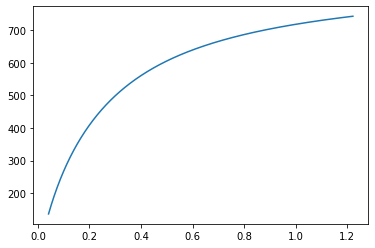

In [140]:
plt.plot(nB*0.153, 8.784820*sigma_array)
plt.plot(nB*0.153, rmf.g_omega*omega)
plt.xlabel('$n_B$ (in fm-3)')
plt.ylabel('MeV')
plt.show()

In [73]:
neutron_frac = np.zeros(len(nB_mev))

def n_frac(elec_frac):
    # baryon num. cons -> 1 = x_n + x_p, charge cons -> x_p = x_e
    return 1.0 - elec_frac

for i in range(len(neutron_frac)):
    neutron_frac[i] = n_frac(electron_frac[i])

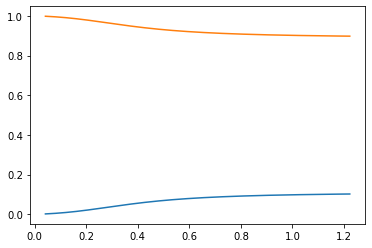

In [74]:
plt.plot(nB*0.153, electron_frac)
plt.plot(nB*0.153, neutron_frac)
plt.show()

## Omega Field
$$
    \omega = \frac{g_\omega}{m_\omega^2}n_B
$$

In [86]:
omega = np.zeros(len(nB))
for i in range(len(nB)):
    omega[i] = rmf.g_omega/omega_num.mass**2*nB_mev[i]
omega
# results match up extremely well with data from Suprovo for this field... 
# up until lambda baryon appears so we'll have to see when we learn how to solve baryonic... 

array([  4.75341305,   4.92946539,   5.10551772,   5.28157006,
         5.45762239,   5.63367473,   5.80972706,   5.9857794 ,
         6.16183174,   6.33788407,   6.51393641,   6.68998874,
         6.86604108,   7.04209341,   7.21814575,   7.39419808,
         7.57025042,   7.74630275,   7.92235509,   8.09840742,
         8.27445976,   8.45051209,   8.62656443,   8.80261676,
         8.9786691 ,   9.15472144,   9.33077377,   9.50682611,
         9.68287844,   9.85893078,  10.03498311,  10.21103545,
        10.38708778,  10.56314012,  10.73919245,  10.91524479,
        11.09129712,  11.26734946,  11.44340179,  11.61945413,
        11.79550646,  11.9715588 ,  12.14761114,  12.32366347,
        12.49971581,  12.67576814,  12.85182048,  13.02787281,
        13.20392515,  13.37997748,  13.55602982,  13.73208215,
        13.90813449,  14.08418682,  14.26023916,  14.43629149,
        14.61234383,  14.78839616,  14.9644485 ,  15.14050084,
        15.31655317,  15.49260551,  15.66865784,  15.84

We want to solve:
$$
    m_\sigma^2 \sigma + \frac{dU}{d\sigma} = \sum_i g_{\sigma i}n^s_i\\
    m_\omega^2 \omega_0 = \sum_i g_{\omega i} n_i\\
    \mu_n = \mu_p + \mu_e\\
    k_p = k_e \quad \leftrightarrow \quad n_p = n_e\\
    n_B = n_n + n_p
$$
Unknowns: $\omega, \sigma, k_p, k_e, k_n$

In [22]:
ns_n = neutron_sym.mass_eff/Pi**2*(neutron_sym.kf*neutron_sym.ef - neutron_sym.mass_eff**2*sym.log((neutron_sym.kf + neutron_sym.ef)/neutron_sym.mass_eff))

In [31]:
ns_new = ns_n.subs(neutron_sym.ef, sym.sqrt(neutron_sym.kf**2 + neutron_sym.mass_eff**2 ))
ns_new = ns_new.subs(neutron_sym.mass_eff, neutron_sym.mass - rmf_sym.g_sigma*sigma_sym.field)
ns_new

(-g_sigma*sigma + m)*(k_F_n*sqrt(k_F_n**2 + (-g_sigma*sigma + m)**2) - (-g_sigma*sigma + m)**2*log((k_F_n + sqrt(k_F_n**2 + (-g_sigma*sigma + m)**2))/(-g_sigma*sigma + m)))/pi**2

In [74]:
def scalar_density(baryon):
    # returns scalar density n_s
    
    coeff_1 = (2*baryon.spin + 1)/(2*Pi**2)
    coeff_2 = baryon.g_sigma*baryon.mass_eff
    term_2 = baryon.ef*baryon.kf 
    term_3 = sym.log((baryon.ef + baryon.kf)/baryon.mass_eff)
    
    return coeff_1*coeff_2*(term_2 - baryon.mass_eff**2*term_3)

In [84]:
def sigma_eom(baryon_list):
    # returns symbolic sigma equation of motion
    
    m_sigma, sigma, b, c, m_n, g_sigma = sym.symbols('m_sigma sigma b c m_n g_sigma')    
    term_1 = m_sigma**2*sigma + b*m_n*g_sigma**3*sigma**2 + c*g_sigma**4*sigma**3
    
    tot = 0
    
    for baryon in baryon_list:
        tot += g_sigma*scalar_density(baryon)

    return term_1 + tot

In [80]:
scalar_density(proton_sym)

1.0*g_sigma*m_p^**(E^*_F_p*k_F_p - m_p^***2*log((E^*_F_p + k_F_p)/m_p^*))/pi**2

In [85]:
sigma_eom([proton_sym, neutron_sym])

b*g_sigma**3*m_n*sigma**2 + c*g_sigma**4*sigma**3 + 1.0*g_sigma**2*m_n^**(E^*_F_n*k_F_n - m_n^***2*log((E^*_F_n + k_F_n)/m_n^*))/pi**2 + 1.0*g_sigma**2*m_p^**(E^*_F_p*k_F_p - m_p^***2*log((E^*_F_p + k_F_p)/m_p^*))/pi**2 + m_sigma**2*sigma

In [114]:
def baryon_chem_pot_simplified(baryon):
    # returns symbolic chemical potential for all mesons
    # we can restrict the number of mesons in our system by setting the coupling constants equal to zero! 
    
    sigma, omega, rho, phi = sym.symbols('sigma omega rho phi')
    return sym.sqrt(baryon.kf**2 + baryon.mass_eff**2) + baryon.g_omega*omega + baryon.g_rho*baryon.isospin*rho + baryon.g_phi*phi

In [113]:
baryon_chem_pot_simplified(proton_sym)

g_omega*omega + sqrt(k_F_p**2 + m_p^***2)

In [101]:
def baryon_fermi(baryon):
    nB = sym.symbols('n_B')
    return (3*Pi**2*nB*baryon.frac)**(sym.S(1)/3)

In [102]:
def baryon_chem_pot_expanded(baryon):
    tot = baryon_chem_pot_simplified(baryon)
    return tot.subs([(baryon.mass_eff, baryon.mass - baryon.g_sigma*sigma), (baryon.kf, baryon_fermi(baryon))])

In [103]:
baryon_chem_pot_expanded(proton_sym)

g_omega*omega + sqrt(3**(2/3)*(n_B*pi**2*x_p)**(2/3) + (-g_sigma*sigma + m)**2)